In [1]:
# Import necessary libraries
import torch
import torch.nn.functional as F

from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision import datasets
from conex import Poisson, Neocortex, InputLayer, Intensity2Latency, prioritize_behaviors, SimpleDendriteStructure, \
    SimpleDendriteComputation, LIF, SpikeTrace, NeuronAxon, KWTA, Fire, ActivityBaseHomeostasis, Synapsis, SynapseInit, \
    WeightNormalization, WeightInitializer, Conv2dDendriticInput, Conv2dSTDP, LateralDendriticInput

from conex.helpers.filters import DoGFilter, GaborFilter
from conex.helpers.transforms.misc import Conv2dFilter, SqueezeTransform
from pymonntorch import NeuronDimension, EventRecorder, NeuronGroup, Recorder, SynapseGroup
from torch.utils.data import DataLoader
from src.decoders import Latency2Intensity

from src.transforms import MinMaxNormalizer

In [2]:
class CustomSimulation:
    def __init__(self, 
                dataloader, 
                device='cpu',
                dtype=torch.float32,
                dt=1,
                instance_duration=2,
                silent_interval=5,
                sensory_size_height=100,
                sensory_size_width=100,
                sensory_trace_tau_s=4,
                input_channels=1,
                l2_kernel_height=11,
                l2_kernel_width=11,
                l2_depth=9,
                l2_height= None,
                l2_width= None,
                l2_threshold=15,
                l2_tau=3,
                l2_v_rest=5,
                l2_v_reset=0,
                l2_R=10,
                l2_trace_tau=3,
                l2_kwta_k=1,
                l2_activity_rate=0.1,
                l2_activity_window_size=None,
                l2_activity_updating_rate=1,
                syn_inp_out_weight_mode="ones",
                syn_inp_out_weight_scale=5,
                syn_inp_out_weight_shape=None,
                syn_inp_out_kernel_shape=None,
                syn_inp_out_coef=300,
                syn_inp_out_AP=2,
                syn_inp_out_AM=1,
                syn_inp_out_wmax=None,
                syn_out_out_weight_mode='ones',
                syn_out_out_weight_scale=0.5,
                syn_out_out_weight_shape=None,
                syn_out_out_kernel_shape=None,
                syn_out_out_lateral_coef=10,
                 **kwargs):
        self.dl = dataloader
        self.device = device
        self.dtype = dtype
        self.dt = dt
        self.instance_duration = instance_duration
        self.silent_interval = silent_interval
        self.sensory_size_height = sensory_size_height
        self.sensory_size_width = sensory_size_width
        self.sensory_trace_tau_s = sensory_trace_tau_s
        self.input_channels = input_channels
        
        self.l2_kernel_height = l2_kernel_height
        self.l2_kernel_width = l2_kernel_width
        self.l2_depth = l2_depth
        
        self.l2_height = l2_height
        if l2_height is None:
            self.l2_height = sensory_size_height - l2_kernel_height + 1
        self.l2_width = l2_width
        if l2_width is None:
            self.l2_width = sensory_size_width - l2_kernel_width + 1
            
        self.l2_threshold = l2_threshold
        self.l2_tau = l2_tau
        self.l2_v_rest = l2_v_rest
        self.l2_v_reset = l2_v_reset
        self.l2_R = l2_R
        self.l2_trace_tau = l2_trace_tau
        
        self.l2_kwta_k = l2_kwta_k
        if l2_activity_window_size is None:
            l2_activity_window_size = instance_duration
        self.l2_activity_window_size = (l2_activity_window_size + silent_interval)*l2_depth
        self.l2_activity_rate = l2_activity_rate*l2_activity_window_size
        self.l2_activity_updating_rate = l2_activity_updating_rate

        self.syn_inp_out_weight_mode = syn_inp_out_weight_mode
        self.syn_inp_out_weight_scale = syn_inp_out_weight_scale
        if syn_inp_out_weight_shape is None:
            self.syn_inp_out_weight_shape = (l2_depth, input_channels, l2_kernel_height, l2_kernel_width)
        if syn_inp_out_kernel_shape is None:
            self.syn_inp_out_kernel_shape = (l2_depth, input_channels, l2_kernel_height, l2_kernel_width)
        self.syn_inp_out_coef = syn_inp_out_coef * l2_kernel_height * l2_kernel_width
        self.syn_inp_out_a_plus = syn_inp_out_AP*(l2_kernel_height*l2_kernel_width) * instance_duration/5
        self.syn_inp_out_a_minus = syn_inp_out_AM*(l2_kernel_height*l2_kernel_width) * instance_duration/5
        self.syn_inp_out_wmax = 0.1
        if syn_inp_out_wmax is None:
            self.syn_inp_out_wmax = 2/(l2_kernel_height*l2_kernel_width)
        
        self.syn_out_out_weight_mode = syn_out_out_weight_mode
        self.syn_out_out_weight_scale = syn_out_out_weight_scale
        self.syn_out_out_weight_shape = syn_out_out_weight_shape
        if syn_out_out_weight_shape is None:
            self.syn_out_out_weight_shape = (1, 1, 2*l2_depth + 1, 1, 1)
        self.syn_out_out_kernel_shape = syn_out_out_kernel_shape
        if syn_out_out_kernel_shape is None:
            self.syn_out_out_kernel_shape = (1, 1, 2*l2_depth + 1, 1, 1)
        self.syn_out_out_lateral_coef = syn_out_out_lateral_coef * l2_kernel_height * l2_kernel_width

        


        ##################################################
        # initializing neocortex
        ##################################################
        self.net = Neocortex(dt=self.dt, device=self.device, dtype=self.dtype)
        
        ##################################################
        # input layer
        ##################################################
        self.input_layer = InputLayer(
            net=self.net,
            input_dataloader=self.dl,
            sensory_size=NeuronDimension(
                depth=1, height=self.sensory_size_height, width=self.sensory_size_width
            ),
            sensory_trace=self.sensory_trace_tau_s,
            instance_duration=self.instance_duration,
            silent_interval=self.silent_interval,
            output_ports={"data_out": (None,[("sensory_pop", {})])}
        )
        self.input_layer.sensory_pop.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="Sensory_event"))
            
        self.output_layer = NeuronGroup(
            net=self.net,
            tag="output",
            size=NeuronDimension(depth=self.l2_depth, height=self.l2_height, width=self.l2_width),
            behavior=prioritize_behaviors(
                [
                    SimpleDendriteStructure(),
                    SimpleDendriteComputation(),
                    LIF(
                        tau=self.l2_tau,
                        v_rest=self.l2_v_rest,
                        v_reset=self.l2_v_reset,
                        threshold=self.l2_threshold,
                        R=self.l2_R,
                    ),
                    KWTA(k=self.l2_kwta_k, dimension=0),
                    Fire(),
                    SpikeTrace(tau_s=self.l2_trace_tau),
                    NeuronAxon(),
                    ActivityBaseHomeostasis(activity_rate=self.l2_activity_rate,
                                            window_size=self.l2_activity_window_size,
                                            updating_rate=self.l2_activity_updating_rate),
                ]
            ),
        )
        self.output_layer.add_behavior(key=351, behavior=EventRecorder(variables=['spikes'], tag="output_layer_event"))
        self.output_layer.add_behavior(key=405, behavior=Recorder(variables=['I', 'spikes'], tag="output_layer_rec"))
        
        
        self.syn_inp_out = Synapsis(
            net=self.net,
            src=self.input_layer.sensory_pop,
            dst=self.output_layer,
            synaptic_tag="Proximal",
            synapsis_behavior=prioritize_behaviors(
                [
                    SynapseInit(),
                    WeightNormalization(),
                    WeightInitializer(mode=self.syn_inp_out_weight_mode, 
                                      scale=self.syn_inp_out_weight_scale, 
                                      weight_shape=self.syn_inp_out_weight_shape,
                                      kernel_shape=self.syn_inp_out_kernel_shape),
                    Conv2dDendriticInput(current_coef=self.syn_inp_out_coef),
                    Conv2dSTDP(a_plus=self.syn_inp_out_a_plus,
                               a_minus=self.syn_inp_out_a_minus,
                               w_max=self.syn_inp_out_wmax,
                               positive_bound="soft_bound",
                               negative_bound="soft_bound",
                               ),
                ]
            ),
        )
        
        self.syn_out_out = SynapseGroup(
           net=self.net,
           src=self.output_layer,
           dst=self.output_layer,
           tag="Proximal",
           behavior=prioritize_behaviors(
               [
                   SynapseInit(),
                   WeightInitializer(mode=self.syn_out_out_weight_mode,
                                     scale=self.syn_out_out_weight_scale, 
                                     weight_shape=self.syn_out_out_weight_shape,
                                     kernel_shape=self.syn_out_out_kernel_shape
                                     ),
                   LateralDendriticInput(inhibitory=True,
                                         current_coef=self.syn_out_out_lateral_coef),
               ]
           )
        )

    def add_info(self,
                 ax,
                 text_x=0.0,
                 text_y=0.05,
                 fontsize=10,
                 **kwargs):
        # params_info = (f"\params:\n"
        #                f"sensory size: {self.sensory_size_height}, {self.sensory_size_width}         activity rate: {self.l2_activity_rate}"
        #                f"kernel size: {self.l2_kernel_height}, {self.l2_kernel_width}           window_size:{self.l2_activity_window_size}"
        #                f"instance duration: {self.instance_duration}        update rate: {self.l2_activity_updating_rate}"
        #                f"silent interval: {self.silent_interval}            kwta K: 1"
        #                f"sensory tau_s: {self.sensory_trace_tau_s}          A_plus, A_minus: {self.syn_inp_out_a_plus}, {self.syn_inp_out_a_minus}")
        params_info = {
            "sensory size": f"{self.sensory_size_height}, {self.sensory_size_width}",
            "kernel size:": f"{self.l2_kernel_height}, {self.l2_kernel_width}",
            "instance duration:": f"{self.instance_duration}",
            "silent interval:": f"{self.silent_interval}",
            "sensory tau_s:": f"{self.sensory_trace_tau_s}",
            "L2 tau_s": f"{self.l2_trace_tau}",
            "Homeostasis activity rate:": f"{self.l2_activity_rate}",
            "Homeostasis window rate": f"{self.l2_activity_window_size}",
            "Homeostasis update rate:": f"{self.l2_activity_updating_rate}",
            "KWTA K": "1",
            "STDP A_plus": f"{self.syn_inp_out_a_plus}",
            "STDP A_minus": f"{self.syn_inp_out_a_minus}",
            "STDP wmax":f"{self.syn_inp_out_wmax}",
            "Lateral Inhibition coef": f"{self.syn_out_out_lateral_coef}"
        }
        params_info = {
            **params_info,
            **kwargs
        }

        formatted_params = "params:\n"
        for key, value in params_info.items():
            formatted_params += f"{key} : {value}\n"

        ax.text(text_x, text_y, formatted_params, transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.4), fontsize=fontsize)


In [3]:
DATASET_ROOT = "../dataset/yale-faces/train"

### Let's take a look at our dataset

In [4]:
dataset = datasets.ImageFolder(root=DATASET_ROOT)

['../dataset/yale-faces/train/1/subject01.normal.pgm', '../dataset/yale-faces/train/10/subject15.normal.pgm', '../dataset/yale-faces/train/2/subject03.normal.pgm', '../dataset/yale-faces/train/3/subject04.normal.pgm', '../dataset/yale-faces/train/4/subject05.normal.pgm']
../dataset/yale-faces/train/1/subject01.normal.pgm
../dataset/yale-faces/train/10/subject15.normal.pgm
../dataset/yale-faces/train/2/subject03.normal.pgm
../dataset/yale-faces/train/3/subject04.normal.pgm
../dataset/yale-faces/train/4/subject05.normal.pgm


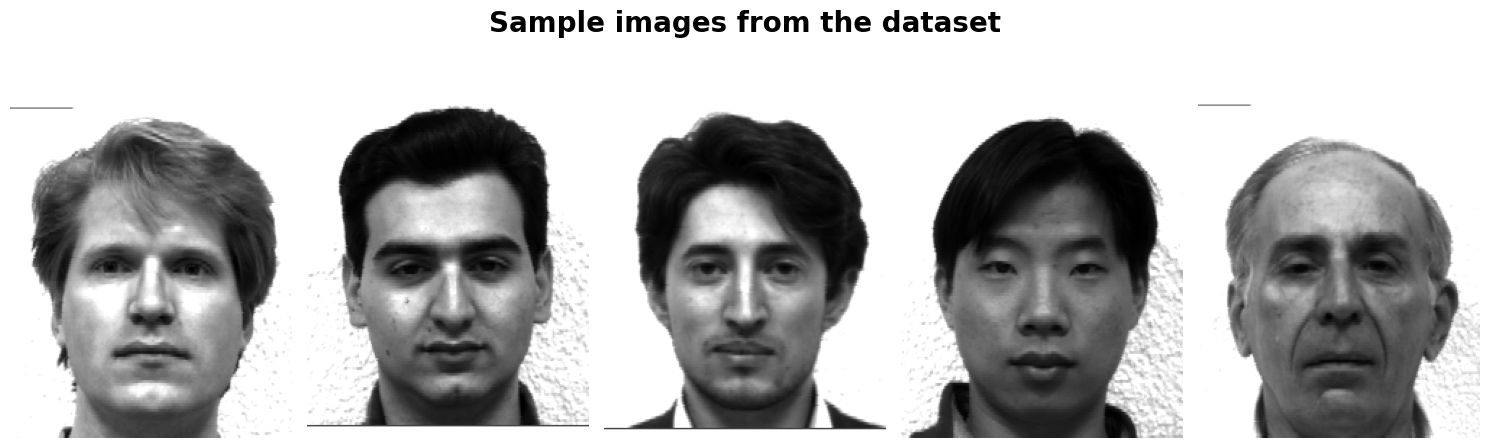

In [5]:
sample_files = [sample[0] for sample in dataset.samples][:5]
# Set up the plot
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
print(sample_files)
for ax, image_file in zip(axes, sample_files):
    # Open the image
    img = Image.open(image_file)
    print(image_file)
    # Plot the image
    ax.imshow(img, cmap='gray')
    ax.axis('off')
fig.suptitle("Sample images from the dataset", fontsize=20, fontweight='bold')
plt.tight_layout()
# plt.savefig("../report/plots/part2-sample-dataset.pdf")
plt.show()